# Determinar el Aglomerado Gran Buenos Aires usando datos abiertos de Open Street Map

In [1]:
#https://datos.minem.gob.ar/informacion-socioeconomica-areas-urbanas-segun-calles-osm
#https://sig.se.gob.ar/geoportal/docs/Ponencia_SE_Nucleos_Poblados_2015.pdf

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import os
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

## Introducción

El objetivo de este trabajo es ofrecer una metodología sencilla para determinar de una manera práctica qué constituye el **Aglomerado Gran Buenos Aires (AGBA)**. El Instituto Nacional de Estadísticas y Censos de Argentina (INDEC) [establece](http://www.indec.gov.ar/nuevaweb/cuadros/4/folleto%20gba.pdf) una distinción entre este y el **Gran Buenos Aires (AGBA)**: *"La diferencia entre el Gran Buenos Aires y el Aglomerado Gran Buenos Aires es que el primero alude a un conjunto de partidos (más la Ciudad de Buenos Aires) tomados en su totalidad, mientras el
segundo alude a un área que se va moviendo con el tiempo y que incluye a algunos partidos de manera
parcial.*

Esta naturaleza cambiante del envolvente de población alude al denominado [Modifiable areal unit problem (MAUP)](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) o *Problema de la Unidad Espacial Modificable (PUEM)*.  En este trabajo buscamos ofrecer una solución rápida y práctica, utilizando datos abiertos de [Open Street Map](https://www.openstreetmap.org/#map=10/-34.7427/-58.6230). La ventaja de este método es, por un lado, su sencillez y rapidez. Por el otro, al ser OpenStreetMap actualizado permanentemente permite mantener actualizados los cambios en el **AGBA** a raíz del avance de urbanización del espacio rural. También permite delimitar hacia el interior del espacio urbano consolidado, radios censales que en su mayoría no contienen espacios residenciales, generando radios de áreas extensas donde no se encuentra realmente población alguna (parques, plazas, zonas industriales, etc.). En las destenvajas se puede enumerar el posible sesgo de recolección de datos por parte de OpenStreetMap, como así también la toma de decisiones arbitrarias de parte nuestra para solucionar algunos escollos.  

El proceso puede ser resumido en las siguientes etapas:

   1. Descargar cartografía de Ciudad Autónoma de Buenos Aires (CABA) y Provincia de Buenos Aires (PBA)
   1. Seleccionar los departamentos considerados por el INDEC como parte del AGBA
   1. Seleccionar aquellos radios censales con baja densidad o caracterizados como de zona mixta por la cédula censal
   1. Descargar calles de Open Street Map
   1. Seleccionar calles residenciales y asignarles un buffer de 100m 
   1. Para cada radio censal seleccionado, obtener el area cubierta por calles residenciales
   1. Seleccionar areas donde las calles residenciales conforme un entramado compacto 
   1. Recortar para los radios seleccionados ese area, asignarles la a=indentificación del radio y descartar el resto del área


## 1. Cartografía 

El INDEC reliza el relevamiento de cada radio censal al cual se le asigna una categoria de urbano, rural o mixto. Esta información no se encuentra disponible aún de manera oficial, aunque puede construirse en base a los radios que publica el Gobierno de la Provincia de Buenos Aires en su [portal de datos abiertos](http://catalogo.datos.gba.gob.ar/dataviews/230038/RADIO-CENSA/) (asumimos que todos los radios de la Ciudad de Buenos Aires son de tipo urbano). Esto es un problema para la reproducibilidad de este trabajo, con el tiempo será subsanada.

In [4]:
#cargo cartografia no oficial de INDEC
home = os.path.expanduser("~")
agba = gpd.GeoDataFrame.from_file(home + '/Downloads/paisNoOficial/rad_paisp.shp')

#construyo el campo LINK como id unica del radio
agba['LINK'] = agba.PROV + agba.DEPTO + agba.FRAC + agba.RADIO
agba.drop([u'DEPTO', u'FRAC', u'PERIMETER', u'PROV', u'RADIO', u'RADPAIS_',
       u'RADPAIS_ID'],axis=1,inplace=True)



## 2. Selección de departamentos pertenecientes al AGBA

En primer lugar se seleccionan los radios pertenecientes a los departamentos que el INDEC considera del AGBA. En segundo lugar se eliminan los radios de tipo rural. Esto nos deja con los radios urbanos y los mixtos. Estos últimos son los que presentarán un desafío a la hora de terminar la porción efectivamente poblada.

In [5]:
#creo el codigo departamento para filtrar los pertenecientes al agba 
agba['DEPARTAMENTO'] = agba.LINK.map(lambda x: x[0:5])

#departamentos AGBA segun INDEC
departamentos = {
    'Comuna 1':'02001',
    'Comuna 2':'02002',
    'Comuna 3':'02003',
    'Comuna 4':'02004',
    'Comuna 5':'02005',
    'Comuna 6':'02006',
    'Comuna 7':'02007',
    'Comuna 8':'02008',
    'Comuna 9':'02009',
    'Comuna 10':'02010',
    'Comuna 11':'02011',
    'Comuna 12':'02012',
    'Comuna 13':'02013',
    'Comuna 14':'02014',
    'Comuna 15':'02015',
    'ALMIRANTE BROWN':'06028',
    'AVELLANEDA':'06035',
    'BERAZATEGUI':'06091',
    'ESCOBAR':'06252',
    'ESTEBAN ECHEVERRIA':'06260',
    'EZEIZA':'06270',
    'FLORENCIO VARELA':'06274',
    'GENERAL RODRIGUEZ':'06364',
    'GENERAL SAN MARTIN':'06371',
    'HURLINGHAM':'06408',
    'ITUZAINGO':'06410',
    'JOSE C PAZ':'06412',
    'LA MATANZA':'06427',
    'LANUS':'06434',
    'LOMAS DE ZAMORA':'06490',
    'MALVINAS ARGENTINAS':'06515',
    'MARCOS PAZ':'06525',
    'MERLO':'06539',
    'MORENO':'06560',
    'MORON':'06568',
    'PILAR':'06638',
    'PRESIDENTE PERON':'06648',
    'QUILMES':'06658',
    'SAN FERNANDO':'06749',
    'SAN ISIDRO':'06756',
    'SAN MIGUEL':'06760',
    'SAN VICENTE':'06778',
    'TIGRE':'06805',
    'TRES DE FEBRERO':'06840',
    'VICENTE LOPEZ':'06861'
}


#se eliminan los departamentos no pertenecientes al AGBA
agba = agba.loc[agba.DEPARTAMENTO.isin(departamentos.values()),:]
agba.drop(['DEPARTAMENTO'],axis=1,inplace=True)

#los radios faltantes correspondientes a CABA son urbanos
agba.TIPO.fillna('U',inplace=True)

#se eliminan los radios rurales 
agba = agba.loc[agba.TIPO!='R',:]

#se agregan etiquetas para los departamentos
#deptos = []
#for i in range(agba.shape[0]):
#    deptos.append(departamentosName[agba.DEPARTAMENTO.iloc[i]])
#agba['DEPTO_NAME'] = deptos

#se proyecta el geodataframe como POSGAR94 Argentina 5 
agba = agba.to_crs(epsg=22185)

agba.head()


,AREA,LINK,TIPO,geometry
26688,16948780.0,062520101,M,"POLYGON ((5605573.523703439 6208535.44525929, ..."
26704,12351870.0,062520102,M,"POLYGON ((5606597.563514996 6207794.426813126,..."
26719,11063170.0,062520208,U,"POLYGON ((5608236.390336967 6207306.631047663,..."
26741,796720.3,062520201,U,"POLYGON ((5611075.149383005 6206034.538516479,..."
26747,2996825.0,062520202,U,"POLYGON ((5613709.611741914 6205445.958880841,..."


In [6]:

departamentosName = {
    '02001':'Comuna 1',
    '02002':'Comuna 2',
    '02003':'Comuna 3',
    '02004':'Comuna 4',
    '02005':'Comuna 5',
    '02006':'Comuna 6',
    '02007':'Comuna 7',
    '02008':'Comuna 8',
    '02009':'Comuna 9',
    '02010':'Comuna 10',
    '02011':'Comuna 11',
    '02012':'Comuna 12',
    '02013':'Comuna 13',
    '02014':'Comuna 14',
    '02015':'Comuna 15',
    '06028':'ALMIRANTE BROWN',
    '06035':'AVELLANEDA',
    '06091':'BERAZATEGUI',
    '06252':'ESCOBAR',
    '06260':'ESTEBAN ECHEVERRIA',
    '06270':'EZEIZA',
    '06274':'FLORENCIO VARELA',
    '06364':'GENERAL RODRIGUEZ',
    '06371':'GENERAL SAN MARTIN',
    '06408':'HURLINGHAM',
    '06410':'ITUZAINGO',
    '06412':'JOSE C PAZ',
    '06427':'LA MATANZA',
    '06434':'LANUS',
    '06490':'LOMAS DE ZAMORA',
    '06515':'MALVINAS ARGENTINAS',
    '06525':'MARCOS PAZ',
    '06539':'MERLO',
    '06560':'MORENO',
    '06568':'MORON',
    '06638':'PILAR',
    '06648':'PRESIDENTE PERON',
    '06658':'QUILMES',
    '06749':'SAN FERNANDO',
    '06756':'SAN ISIDRO',
    '06760':'SAN MIGUEL',
    '06778':'SAN VICENTE',
    '06805':'TIGRE',
    '06840':'TRES DE FEBRERO',
    '06861':'VICENTE LOPEZ'
}


## 3. Seleccionar los radios con baja densidad o de zonas mixtas

Utilizando el [sistema de consulta](http://200.51.91.245/argbin/RpWebEngine.exe/PortalAction?&MODE=MAIN&BASE=CPV2010B&MAIN=WebServerMain.inl) para el Censo 2010 de REDATAM en el sitio oficial de INDEC, se obtiene la cantidad de población de cada radio para la provincia de Buenos Aires como para la Ciudad, con el objetivo de estimar la densidad poblacional. 

In [7]:
#esta data fue descargada desde la pagina oficial de indec 
#http://200.51.91.245/argbin/RpWebEngine.exe/PortalAction?&MODE=MAIN&BASE=CPV2010B&MAIN=WebServerMain.inl
#obteniendo listado por areas a nivel de radio censal
#sexo, con total de filas, para: 

#los 24 partidos del Gran Benos Aires
pbaPob = pd.read_csv('../dt/poblacionPBAcenso.csv')
pbaPob.LINK = pbaPob.LINK.map(lambda x: '0'+str(x))


#CABA 
cabaPob = pd.read_csv('../dt/poblacionCABAcenso.csv')
cabaPob.LINK = cabaPob.LINK.map(lambda x: '0'+str(x))

poblacion = cabaPob.append(pbaPob)

#se agregan los datos a la tabla de agba con la geografia
agba = agba.merge(poblacion, on='LINK',how='left')

#se calcula la densidad de cada radio censal y se la divide en 
agba['densidad'] = agba.Pob / agba.AREA
agba['densidad'] = pd.qcut(agba.densidad,10,labels=False)

In [8]:
pd.crosstab(agba.densidad,agba.TIPO)

TIPO,,M,U
densidad,,,
0,65,76,1204
1,55,0,1290
2,75,0,1269
3,89,0,1256
4,111,1,1232
5,159,0,1186
6,305,0,1039
7,557,0,788
8,940,0,404


Como es de esperar los radios mixtos se encuentran en el primer decil de densidad demográfica (esto es decir, el grupo con menor densidad). Existe una excepcion 

In [9]:
idRadioEspecial = agba.LINK[(agba.TIPO == 'M') & (agba.densidad == 4)].iloc[0]
radioEspecial = agba.loc[agba.LINK == idRadioEspecial,:].copy()
punto = radioEspecial.geometry.iloc[0].centroid
radioEspecial.geometry.iloc[0] = punto

print idRadioEspecial

065391015


/home/pipe/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Como se explicó al principio nuestor interés se encuentra en los radios que no se encuentran poblados en toda su extensión. Esto puede ser porque son radios de tipo mixto ubicados en los bordes del área urbana o porque, aún encontrándose dentro de un ámbito urbano consolidado, presentan grandes extensiones sin poblar (grandes parques por ejemplo). Por lo tanto los radios que son de nuestro interés son aquellos que son de tipo mixto o que son de baja densidad. Crearemos dos tablas, una que contenga los radios que intuimos estan poblados en su totalidad y no nos interesa determinar el area realmente poblada y la otra con los radios en los cuales utilizaremos las calles de OSM para detemrinar dicha area. 

In [10]:
#se crea un vector que identifique los radios de baja densidad o de tipo mixto
mixYden = (agba.TIPO == 'M') | (agba.densidad == 0)
agba['mixYden'] = mixYden

agba.drop(['AREA','Pob','TIPO','densidad'], axis=1,inplace=True)
#se crean dos tablas de datos, una con los radios de interes y otra con los radios
agbaAltaDens = agba.loc[~agba.mixYden,:]
agbaBajaDens = agba.loc[agba.mixYden,:]


agba.head()

,LINK,geometry,mixYden
0,062520101,"POLYGON ((5605573.523703439 6208535.44525929, ...",True
1,062520102,"POLYGON ((5606597.563514996 6207794.426813126,...",True
2,062520208,"POLYGON ((5608236.390336967 6207306.631047663,...",True
3,062520201,"POLYGON ((5611075.149383005 6206034.538516479,...",True
4,062520202,"POLYGON ((5613709.611741914 6205445.958880841,...",True


In [11]:
agba['tipo'] = ''
agba['tipo'][agba.mixYden] = 'Baja densidad o mixto'
agba['tipo'][~agba.mixYden] = 'Alta densidad o urbano'
agba.drop(['mixYden'],axis=1,inplace = True)
agba.head()

/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,LINK,geometry,tipo
0,062520101,"POLYGON ((5605573.523703439 6208535.44525929, ...",Baja densidad o mixto
1,062520102,"POLYGON ((5606597.563514996 6207794.426813126,...",Baja densidad o mixto
2,062520208,"POLYGON ((5608236.390336967 6207306.631047663,...",Baja densidad o mixto
3,062520201,"POLYGON ((5611075.149383005 6206034.538516479,...",Baja densidad o mixto
4,062520202,"POLYGON ((5613709.611741914 6205445.958880841,...",Baja densidad o mixto


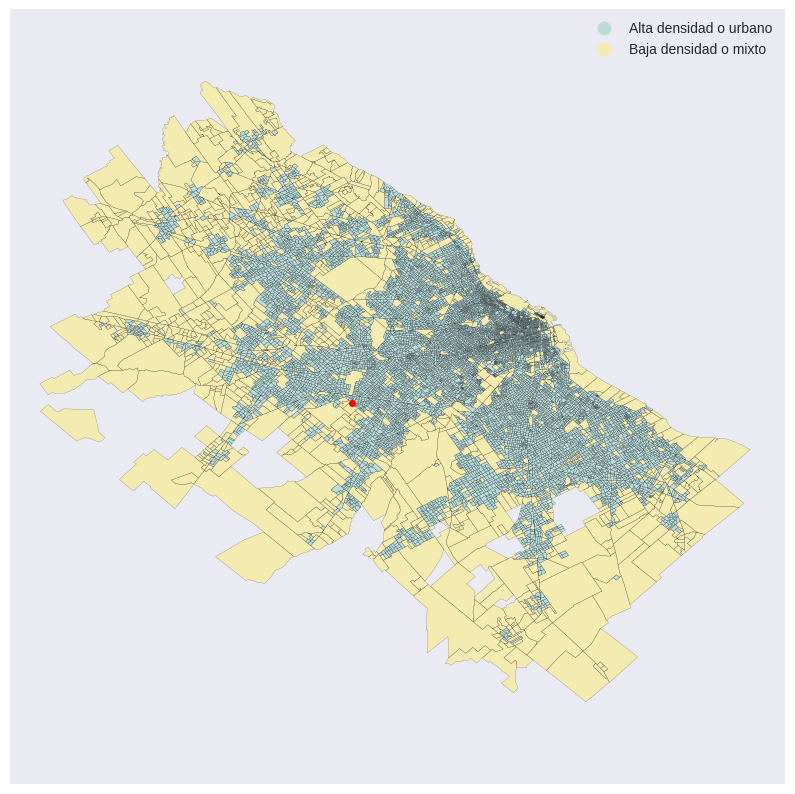

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

agba.plot(ax=ax,linewidth=0.1, column = 'tipo',cmap='Set3',legend = True)
radioEspecial.plot(ax=ax, color = 'red', markersize=5,label = 'Radio mixto densidad media', legend = True)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



In [13]:
agba.drop(['tipo'],axis=1,inplace=True)

In [14]:
agba.to_file('../dt/carto/agba')

## 4. Descargar data de OpenSteetMap

Open Street Map posee archivos con las calles de numerosas ciudades del mundo. Las mismas a su vez se catalogan en una [tipología](http://wiki.openstreetmap.org/wiki/Key:highway). Utilizamos el servicios de Mapzen porque ofrece los datos para una zona extensa de Buenos Aires y alrededores.



In [15]:
#download data
osmFile = home + '/Downloads/buenos-aires_argentina.osm2pgsql-shapefiles/buenos-aires_argentina_osm_line.shp'
if not os.path.isfile(osmFile):
    os.sys('wget https://s3.amazonaws.com/metro-extracts.mapzen.com/buenos-aires_argentina.osm2pgsql-shapefiles.zip')
    os.sys('unzip https://s3.amazonaws.com/metro-extracts.mapzen.com/buenos-aires_argentina.osm2pgsql-shapefiles.zip')

calles = gpd.read_file(home + '/Downloads/buenos-aires_argentina.osm2pgsql-shapefiles/buenos-aires_argentina_osm_line.shp')
calles = calles.loc[:,['highway','geometry']]


## 5. Seleccionar calles residenciales y computar un buffer de 100 metros

A continuación seleccionamos las calles que consideramos son típicas de una zona residencial. A las mismas le aplicamos un área alrededor de 100 metros. A su vez seleccionamos las calles de un largo menor a 2 km para evitar seleccionar areas constituidas unicamente por una sola calle.

| Residential| Living street        | 
| ------------- |:-------------:|
| ![residential](http://wiki.openstreetmap.org/w/images/3/30/Residential.jpg)     | ![Living street](http://wiki.openstreetmap.org/w/images/6/6a/Spielstrasse.jpg) |
| **Footway**| **Pedestrian**        | 
|      ![Footway](http://wiki.openstreetmap.org/w/images/6/64/Dscf0487_600.jpg) |  ![Pedestrian](https://upload.wikimedia.org/wikipedia/commons/1/1c/Cambridge_Rd_-_geograph.org.uk_-_1189572.jpg)|


In [16]:
#se eligen el tipo de calles que asumimos constituyen parte de un area urbana
mask =  (calles.highway == 'residential') |  (calles.highway == 'living_street') | (calles.highway == 'footway') |  (calles.highway == 'pedestrian') 
calles = calles.loc[mask,:]

#se proyecta el geodataframe con la misma proyeccion que los radios POSGAR94 Argentina 5 
calles = calles.to_crs(epsg=22185)

#se detemrina el largo de la linea
calles['largo'] = calles.geometry.map(lambda x: x.length)

#se selecciona las calles con un largo menos a 2 kilometros
calles = calles.loc[calles.largo <= 2000,:]
calles.drop(['largo'],axis=1,inplace = True)

calles['buffer'] = calles.geometry.buffer(100)
calles.drop(['geometry'],axis=1,inplace=True)
calles.columns = [u'highway', u'geometry']

## 6. Obtener el area del radio cubierta por calles residenciales

Nuetros problema parte de poder indentificar en aquellos radios no plenamente poblados, que porción se encuentra poblada efectivamente. El objetivo final es obtener un polígono con dicha zona. Asumimos que dicha area tendrá calles que Open Street Map considera dentro de la tipología que mencionamos previamente. Procederemos a escoger el area del radio que **inersecta** con las calles (a las que convertimos en polígonos utilizando un buffer de 100 metros). Escojemos a continuación un radio para ejemplificar cómo procedemos. 

### 6.1 Ejecución en un subset de datos a modo de ejemplo 

In [17]:
#selecionamos los radios a utilizar
radiosSel = gpd.read_file('dataPrueba/radiosSeleccionados.shp')

#seleccionamos una calle que atraviesa dichos radios
calleConectada = gpd.read_file('dataPrueba/calleConConexion.shp')
calleConectada['buffer'] = calleConectada.geometry.buffer(70)
calleConectada.drop(['geometry'],axis=1,inplace=True)
calleConectada.columns = [u'highway', u'geometry']


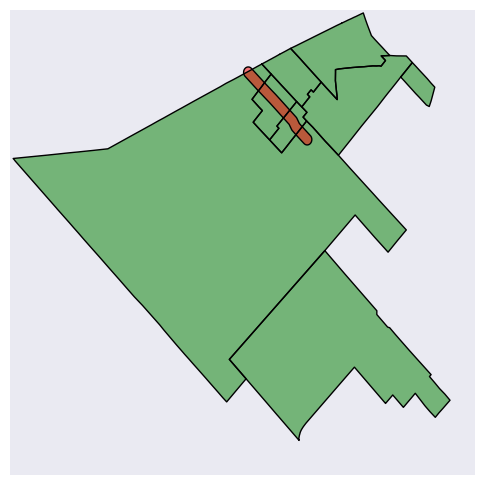

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
calleConectada.plot(ax=ax,color='red')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [19]:
#obtenemos el area que donde se intersectan el polígono del radio y el polígono de las calles
intersec = gpd.overlay(radiosSel, calleConectada, how='intersection')
intersec

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621831.386868679 6159061.582841514,..."
1,297245.6,06539,MERLO,065391008,2204,U,3,residential,"POLYGON ((5621789.358866802 6159012.434962539,..."
2,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5622304.19733424 6158390.687202398, ..."
3,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5622352.559752863 6158443.872580742,..."


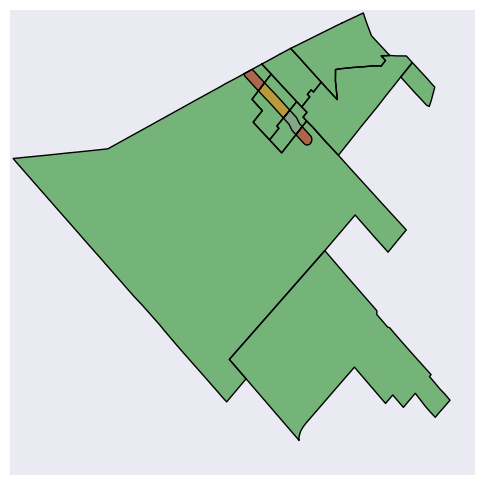

In [20]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
intersec.plot(ax=ax,column='LINK')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


Como se puede observar, el polígono de la calle queda segmentado de acuerdo al radio al que pertenece. Eventualmente realizaremos esto con todas las calles, obteniendo la intersección de las mismas con todos los radios, y disolviendo todas estas areas para cada radio. Obviamente algunas calles no se intersectan con algunos radios. En este caso la operación *overlay* de **Geopandas** directamente arroja un *geodataframe* vacío. De todos modos esto se resolverá de otro modo que mostraremos más adelante. Para continuar, seleccionamos otra calle para demostrar como funciona el proceso *dissolve*

In [21]:
calleConectada2 = gpd.read_file('dataPrueba/calleConConexion2.shp')
calleConectada2['buffer'] = calleConectada2.geometry.buffer(70)
calleConectada2.drop(['geometry'],axis=1,inplace=True)
calleConectada2.columns = [u'highway', u'geometry']



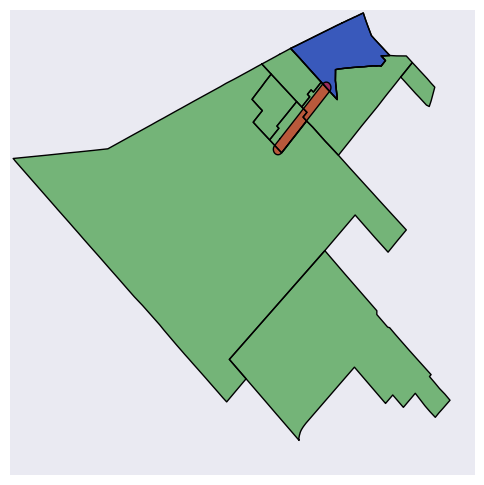

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
radiosSel.loc[radiosSel.LINK == '065391011',:].plot(ax=ax,color='blue')
calleConectada2.plot(ax=ax,color='RED')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



In [23]:
#realizamos el proceso de overlay con intersection como parametro 
intersec2 = gpd.overlay(radiosSel, calleConectada2, how='intersection')
#agregamos a esta tabla, la tabla obtenida por el proceso anterior de interseccion
appenDF = intersec2.append(intersec)
#disolvemos los poligonos por el campo LINK, obteniendo un unico poligono para cada radio 
appenDFdiss = appenDF.dissolve(by='LINK')


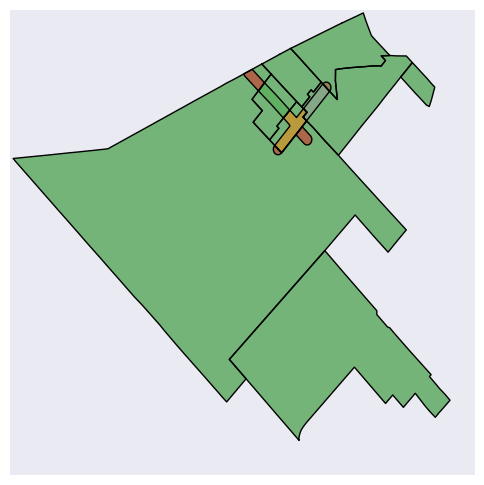

In [24]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
appenDFdiss.reset_index().plot(ax=ax,column='LINK')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



### 6.2  Ejecución en el total del conjunto de datos

La situación normal es que una calle no intersecte con la mayoría de los radios, sino más bien con unos pocos. Por lo tanto, para no cruzar cada una de las calles con cada uno de los radios para todos los radios y todas las calles, primero realizamos un *spatial join* para saber qué calles atraviesan cada radio. 

In [25]:
calles.drop(['highway'],axis=1,inplace=True)
calles['calleID'] = calles.index
#a cada calle le asigno el radio al que pertenece mediante un spatial join
#una calle puede atravesar mas de un radio, por eso van a aparecer calles repedidas en la tabla
calles = gpd.sjoin(calles, agbaBajaDens.loc[:,['geometry','LINK']], how="inner", op='intersects')
calles.reset_index(inplace=True)
calles.drop(['index','index_right'],axis=1,inplace=True)
calles.head()

,geometry,calleID,LINK
0,"POLYGON ((5585797.157224065 6157690.710567379,...",279,063640504
1,"POLYGON ((5585766.893090877 6157819.541789982,...",280,063640504
2,"POLYGON ((5585824.361333102 6157929.274601583,...",281,063640504
3,"POLYGON ((5585928.447176262 6157857.453439912,...",282,063640504
4,"POLYGON ((5585901.694404183 6157967.977852936,...",283,063640504


Luego repetimos la operación descrita en el ejemplo, para el conjunto de los datos, una calle por vez y realizando la intersección solo para los radios a los que esa calle atraviesa.

In [26]:
primerID = calles.calleID.unique()[0]
counter = 0
for i in calles.calleID.unique():
    #para cada calle
    subset = calles.loc[calles.calleID==i,:]
    #selecciono de a una calle
    unaLinea = subset.iloc[0:1,:]
    #de todos los radios, selecciono los que interseccionan esta calle
    conjuntoDeRadios = agbaBajaDens.loc[agbaBajaDens.LINK.isin(subset.LINK),:]
    #realizo una intercepcion
    if i == primerID:
        intercept = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
    else:
        tmp = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
        intercept = intercept.append(tmp)
    counter += 1
        
    print '\r',"%",str((counter+1)*100./len(calles.calleID.unique()))[:4],

% 100.


In [28]:
intercept = intercept.loc[:,['LINK','geometry']]
intercept.head()

,LINK,geometry
0,063640504,"POLYGON ((5585876.703430125 6157766.650889304,..."
0,063640504,"POLYGON ((5585816.305761689 6157867.002179299,..."
0,063640504,"POLYGON ((5585652.716804017 6158033.904114954,..."
0,063640504,"POLYGON ((5585735.918334833 6157949.005015798,..."
0,063640504,"POLYGON ((5585654.270403223 6158032.318814625,..."


El resultado que obtenemos es una serie de poligonos de las calles recortados dentro del radio al que pertenece el segmento de esa calle. El paso siguiente es disolver todos los poligonos que esten dentro del mimso radios, es decir que compartan el mismo LINK, en un solo polígono.

In [29]:
primerLINKid = intercept.LINK.unique()[0]
for i in intercept.LINK.unique():
    if i == primerLINKid:
        dissolve = intercept.loc[intercept.LINK==i,:].dissolve(by='LINK').reset_index()
    else:
        try:
            tmp = intercept.loc[intercept.LINK==i,:].dissolve(by='LINK').reset_index()
        except:
            #tomo los intercepts dentro de un radio por su LINK
            tmp = intercept.loc[intercept.LINK==i,:]
            #creo el primer elemento de la cascade_union
            geoConError = tmp.geometry.iloc[0]
            for i in range(1,tmp.shape[0]):
                geoConError = shapely.ops.cascaded_union([geoConError,tmp.geometry.iloc[i]])
            tmp = tmp.iloc[0:1,:].reset_index().drop(['index'],axis=1)
            tmp['geometry'][0] = geoConError
            
        dissolve = dissolve.append(tmp)
            


TopologyException: found non-noded intersection between LINESTRING (5.64429e+06 6.13899e+06, 5.64435e+06 6.13908e+06) and LINESTRING (5.64435e+06 6.13908e+06, 5.64434e+06 6.13906e+06) at 5644348.837400442 6139080.3267585943
TopologyException: found non-noded intersection between LINESTRING (5.64429e+06 6.13899e+06, 5.64435e+06 6.13908e+06) and LINESTRING (5.64435e+06 6.13908e+06, 5.64434e+06 6.13906e+06) at 5644348.837400442 6139080.3267585943
TopologyException: found non-noded intersection between LINESTRING (5.60281e+06 6.16622e+06, 5.60283e+06 6.16623e+06) and LINESTRING (5.60281e+06 6.16622e+06, 5.60281e+06 6.16622e+06) at 5602814.4831207125 6166222.2533008074
TopologyException: found non-noded intersection between LINESTRING (5.60281e+06 6.16622e+06, 5.60283e+06 6.16623e+06) and LINESTRING (5.60281e+06 6.16622e+06, 5.60281e+06 6.16622e+06) at 5602814.4831207125 6166222.2533008074
TopologyException: found non-noded intersection between LINESTRING (5.59847e+06 6.17144e+06, 5.59846e+

In [30]:
#se convierte el geodataframe con una geometria sin proyeccion establecida a una en Posgar
dissolve = gpd.GeoDataFrame(dissolve, geometry="geometry", crs=agba.crs)
dissolve = dissolve.reset_index().drop(['index'],axis=1)
agbaAltaDens = agbaAltaDens.reset_index().drop(['index','mixYden'],axis=1)

In [33]:
#se agregan a los polígonos de alta densidad y urbanos, los nuevos poligonos recortados en base a OSM
agbaOSM = agbaAltaDens.append(dissolve)
agbaOSM.head()

,LINK,geometry
0,062520209,"POLYGON ((5612723.096547182 6201186.305513684,..."
1,062520216,"POLYGON ((5611865.994244184 6200953.547424132,..."
2,062520105,"POLYGON ((5610396.67145441 6200626.129762402, ..."
3,062520217,"POLYGON ((5611665.072409396 6200842.464373552,..."
4,062520104,"POLYGON ((5610396.67145441 6200626.129762402, ..."


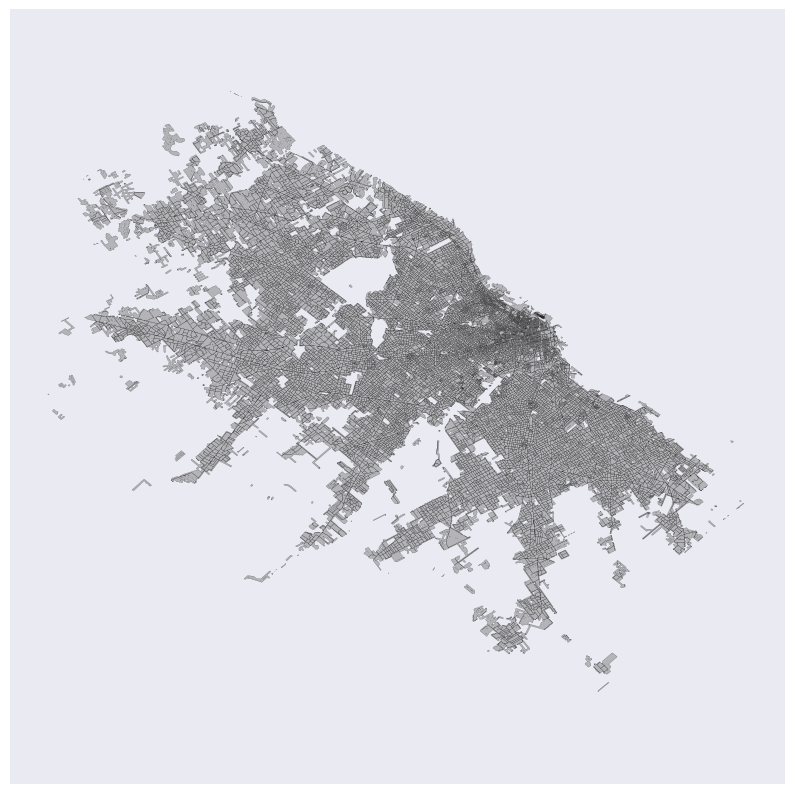

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

agbaOSM.plot(ax=ax,linewidth=0.1, color='gray')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [ ]:
agbaOSM.to_file('../dt/carto/agbaOSM/')